In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import scipy.misc
from time import time
import coremltools
%matplotlib notebook

# Process the input image

- Load the image (color and luminance)
- Predict the classes

<IPython.core.display.Javascript object>


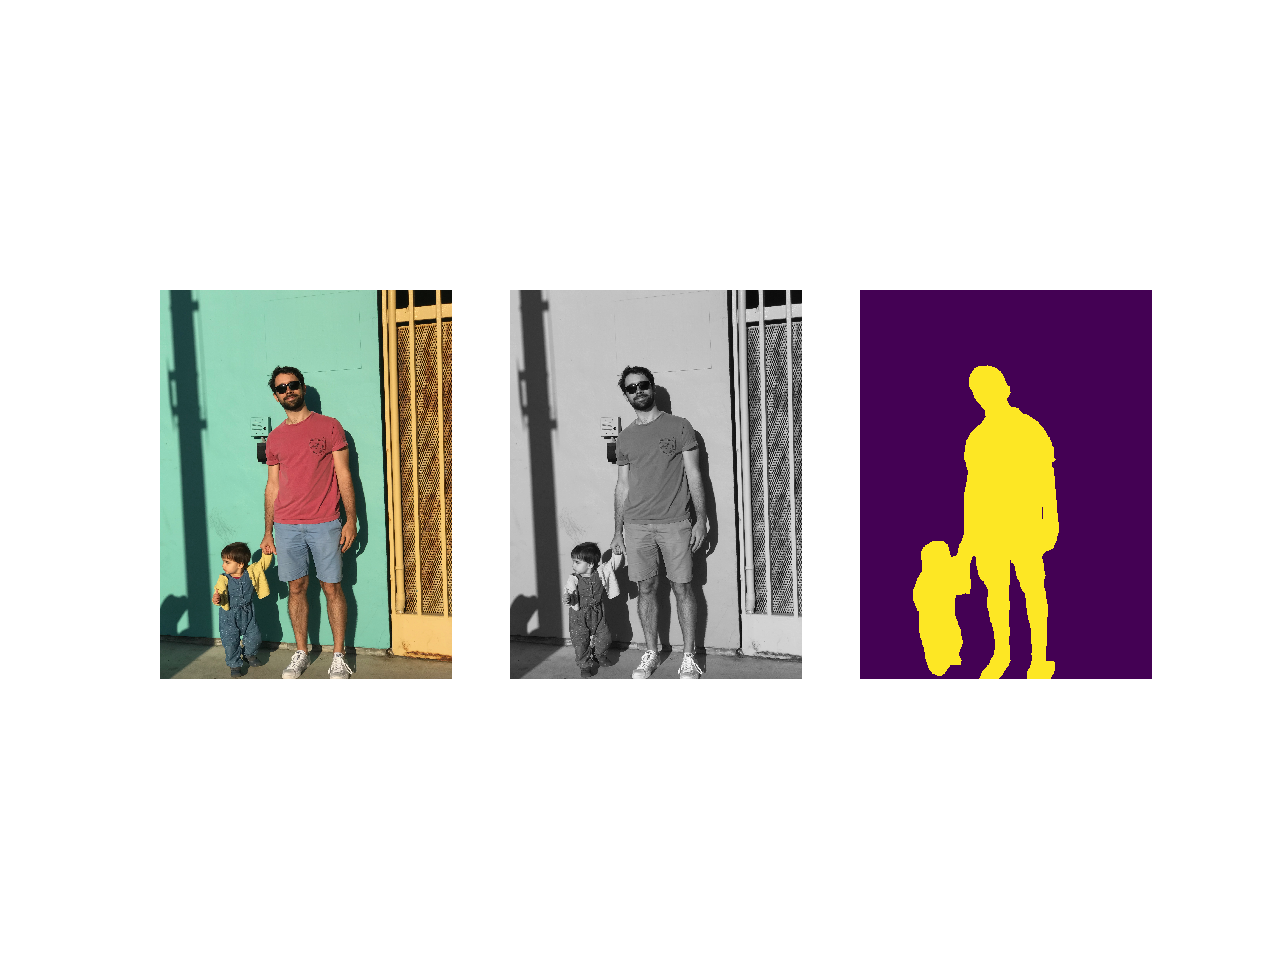

In [17]:
# Load the image
img_rgb = Image.open('../samples/person_matthieu.jpg')
img_y = img_rgb.convert('L')

# Load the model and it's specs
model = coremltools.models.MLModel('../models/DeepLab.mlmodel')
input_width = model.get_spec().description.input[0].type.imageType.width
input_height = model.get_spec().description.input[0].type.imageType.height

# Resize the image to fit model's input size
small_img = img_rgb.resize((input_width, input_height), Image.BILINEAR)

# Predict the classes
y = model.predict({"image": small_img}, usesCPUOnly=False)
small_pred = y['scores']

# Resize the prediction to input image size
pred = small_pred.resize((img_rgb.width, img_rgb.height), PIL.Image.NEAREST)

# Plot
f, ax = plt.subplots(1,3)
ax[0].imshow(img_rgb)
ax[1].imshow(img_y, cmap='gray')
ax[2].imshow(pred)
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()
plt.show()

# Compute the object mask

- Convert images to numpy
- Display statistics

In [18]:
# Convert images
guide = np.array(img_y).astype(np.float32) / 255.
pred2 = np.array(pred) / 12

# List of labels
labels = ['Background','Plane','Bicycle','Bird','Boat','Bottle','Bus','Car','Cat','Chair','Cow','Diningtable','Dog','Horse','Motorbike','Person','Pottedplant','Sheep','Sofa','Train','Tvmonitor']
label2id = {'Background':0,'Plane':1,'Bicycle':2,'Bird':3,'Boat':4,'Bottle':5,'Bus':6,'Car':7,'Cat':8,'Chair':9,'Cow':10,'Diningtable':11,'Dog':12,'Horse':13,'Motorbike':14,'Person':15,'Pottedplant':16,'Sheep':17,'Sofa':18,'Train':19,'Tvmonitor':20}

# Print statistics
print('Statistics:')
nb_pixels = pred2.size
for i in range(len(labels)):
    nb_pixels_for_class = float(len(np.nonzero(pred2 == i)[0]))
    print("  %-12s : %4.1f %%" % (labels[i], 100 * nb_pixels_for_class / nb_pixels))

Statistics:
  Background   : 78.5 %
  Plane        :  0.0 %
  Bicycle      :  0.0 %
  Bird         :  0.0 %
  Boat         :  0.0 %
  Bottle       :  0.0 %
  Bus          :  0.0 %
  Car          :  0.0 %
  Cat          :  0.0 %
  Chair        :  0.0 %
  Cow          :  0.0 %
  Diningtable  :  0.0 %
  Dog          :  0.0 %
  Horse        :  0.0 %
  Motorbike    :  0.0 %
  Person       : 21.5 %
  Pottedplant  :  0.0 %
  Sheep        :  0.0 %
  Sofa         :  0.0 %
  Train        :  0.0 %
  Tvmonitor    :  0.0 %


<IPython.core.display.Javascript object>


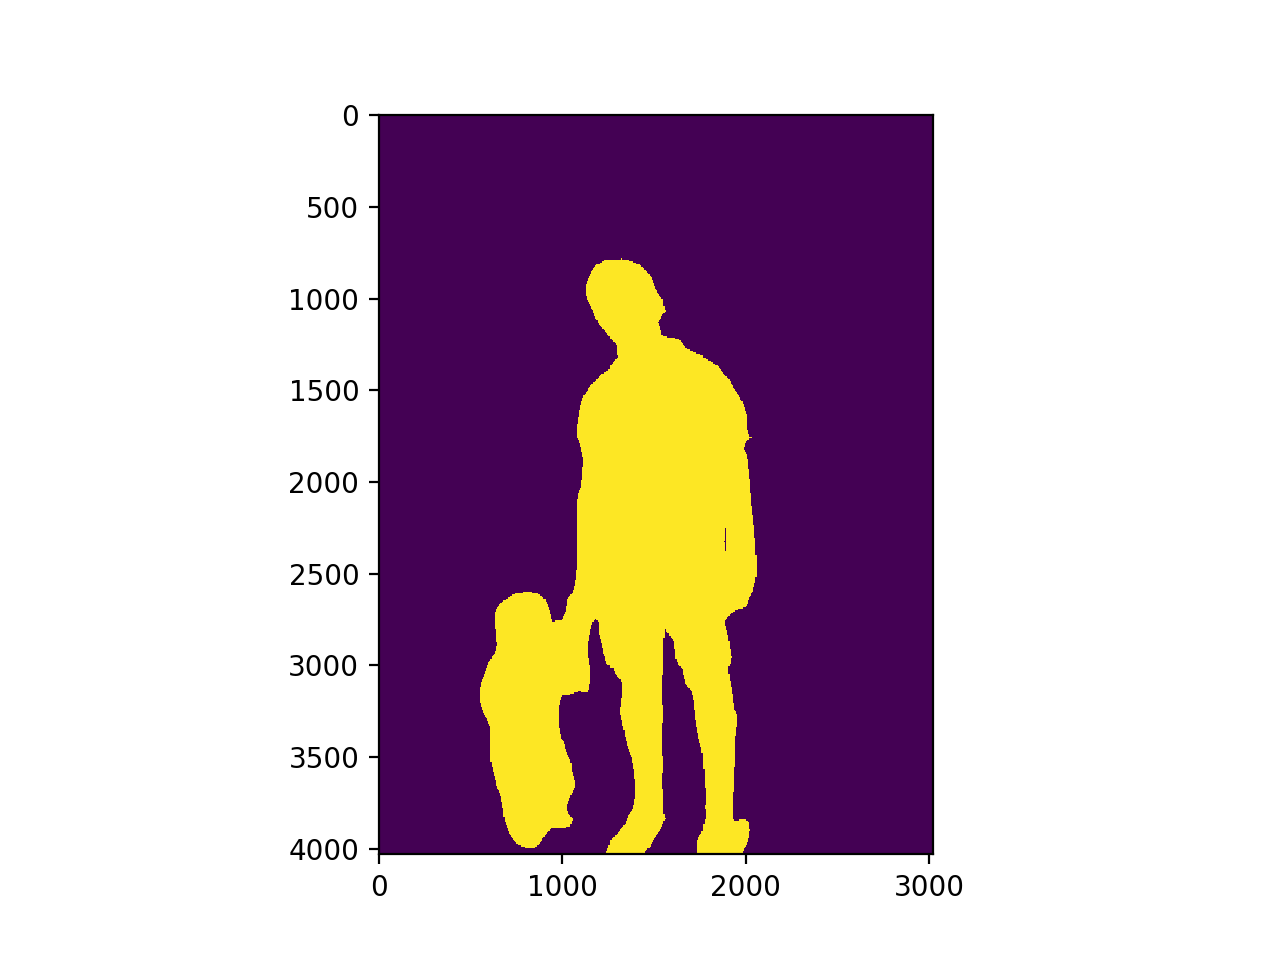

In [19]:
# Specify the class label you are interested in
label = 'Person'

# Compute the associated mask
mask = np.zeros(pred2.shape, dtype=np.float32)
mask[pred2 == label2id[label]] = 1.

# Plot
plt.figure()
plt.imshow(mask)
plt.show()

# Guided filter

Elapsed time V1 :  4.240 s


<IPython.core.display.Javascript object>


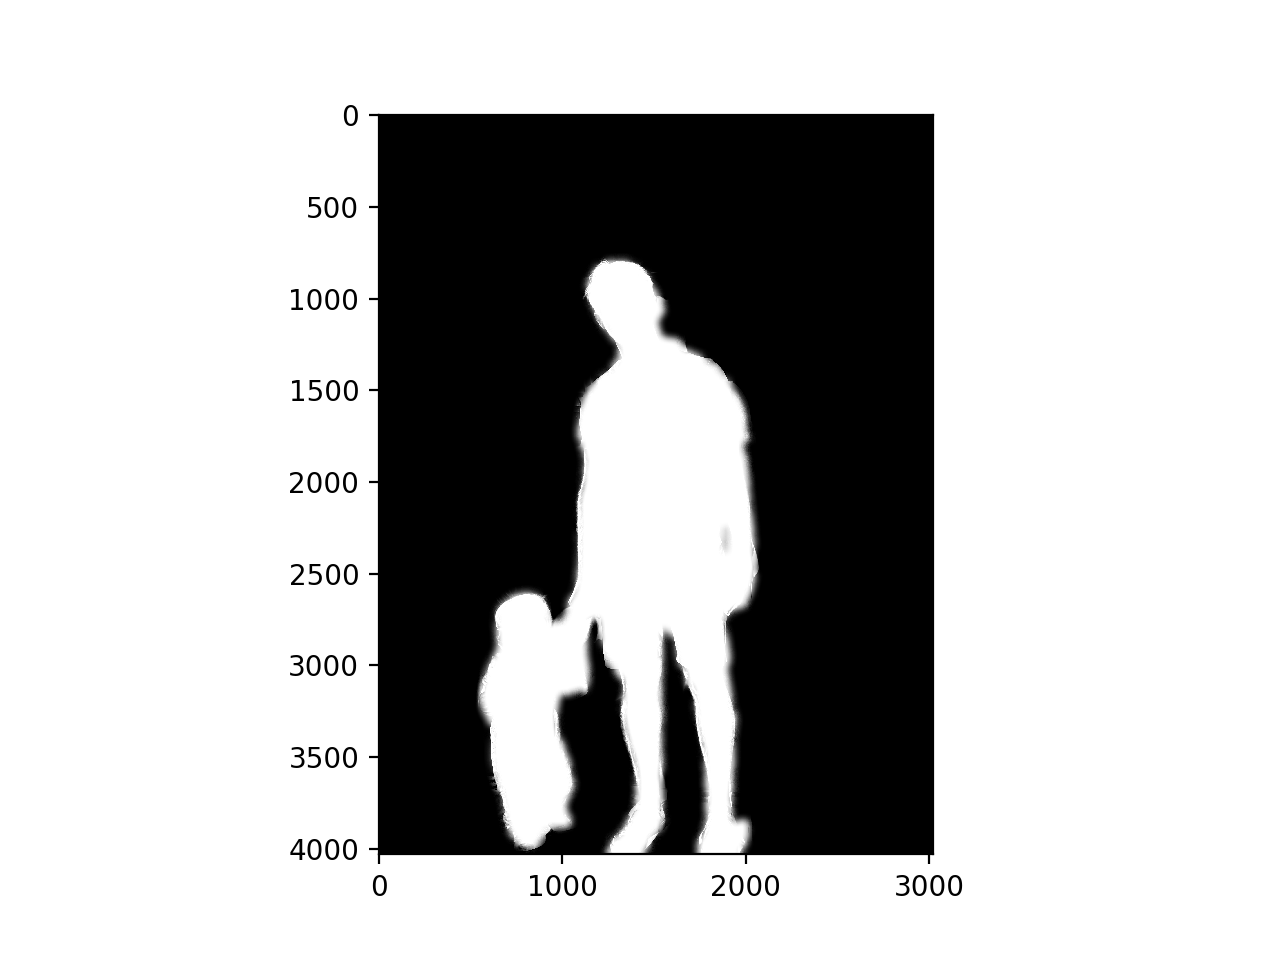

In [20]:
def box_filter(img, r):

    height, width = img.shape

    # Vertical pass
    iiv = np.cumsum(img, axis=0)
    img2 = np.zeros(img.shape, dtype=np.float)
    img2[0:r+1, :] = iiv[r:2*r+1, :] / np.array(range(r+1, 2*r+2)).reshape((r+1,1))
    img2[r+1:height-r, :] = (iiv[2*r+1:height, :] - iiv[0:height-2*r-1, :]) / (2*r+1)
    img2[height-r:height,:] = (iiv[height-1,:] - iiv[height-2*r-1:height-r-1,:]) / np.array(range(2*r, r, -1)).reshape((r,1))

    # Horizontal pass
    iih = np.cumsum(img2, axis=1)
    img3 = np.zeros(img.shape, dtype=np.float)
    img3[:, 0:r+1] = iih[:, r:2*r+1] / np.array(range(r+1, 2*r+2)).reshape((1, r+1))
    img3[:, r+1:width-r] = (iih[:, 2*r+1:width] - iih[:, 0:width-2*r-1]) / (2*r+1)
    img3[:, width-r:width] = (np.expand_dims(iih[:,width-1], axis=1) - iih[:,width-2*r-1:width-r-1]) / np.array(range(2*r, r, -1)).reshape((1,r))

    return img3


def guided_filter(I, p, radius, eps):

    # Compute I * p
    Ip = np.multiply(I, p)
    I2 = I**2

    # Compute some values
    I_mean = box_filter(I, radius)
    p_mean = box_filter(p, radius)
    Ip_mean = box_filter(Ip, radius)
    I2_mean = box_filter(I2, radius)
    I_var = I2_mean - I_mean**2

    # Compute a and b
    a = (Ip_mean - np.multiply(I_mean, p_mean)) / (I_var + eps)
    b = p_mean - np.multiply(a, I_mean)

    # Deduce a_mean and b_mean
    a_mean = box_filter(a, radius)
    b_mean = box_filter(b, radius)

    # Finally get the output mask
    q = np.multiply(a_mean, I) + b_mean

    # Clip values in [0,1]
    q = np.clip(q, 0, 1)

    return q


# Test the guided filter
radius = 20
eps = 0.0001

tic = time()
q = guided_filter(guide, mask, radius, eps)
toc = time()
print('Elapsed time V1 : %6.3f s' % (toc-tic))

plt.figure()
plt.imshow(q, cmap="gray")
plt.show()

<IPython.core.display.Javascript object>


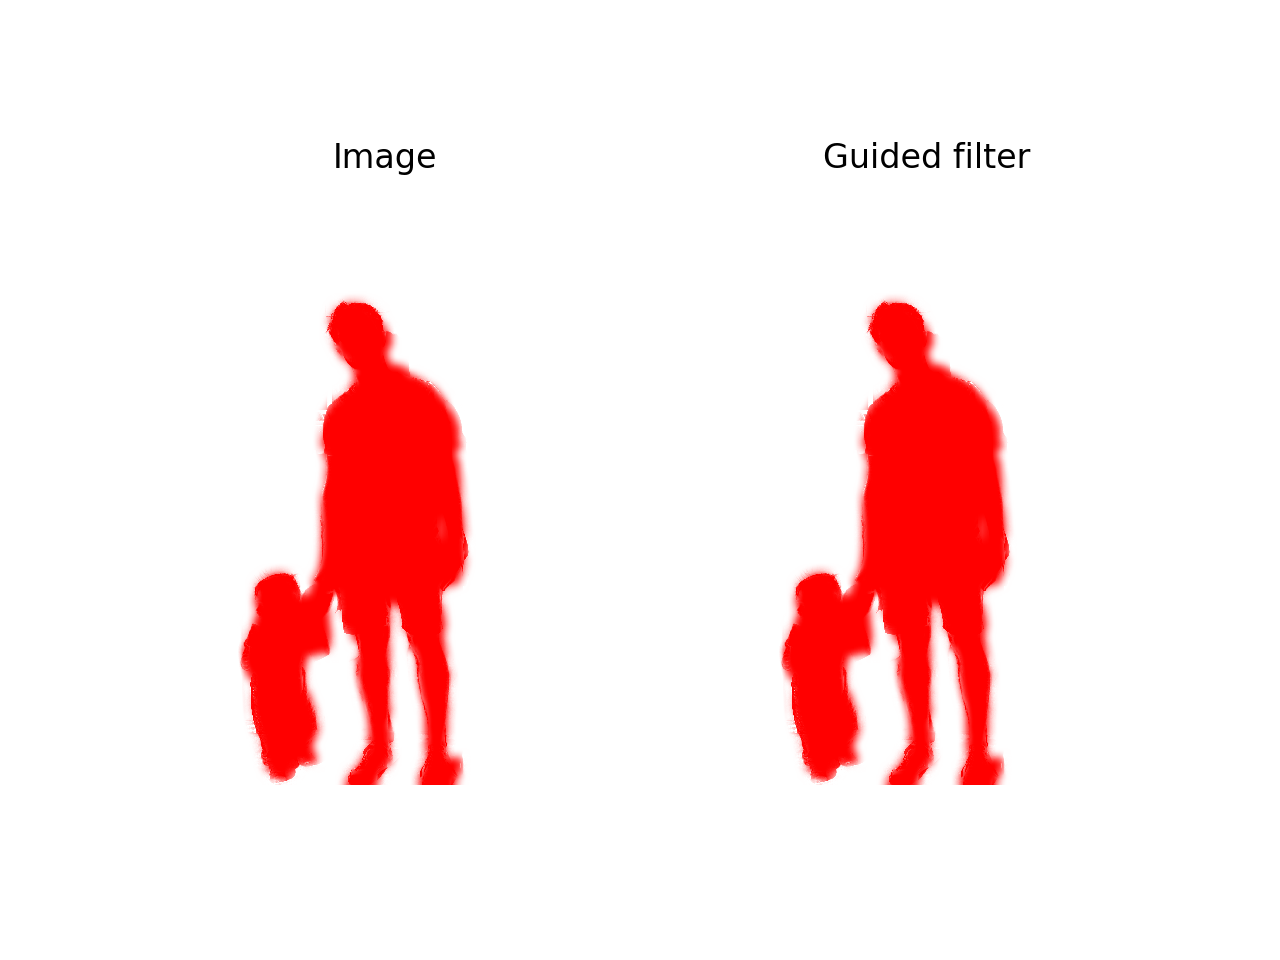

aW50ZXJhY3RpdmUoY2hpbGRyZW49KENoZWNrYm94KHZhbHVlPUZhbHNlLCBkZXNjcmlwdGlvbj11J2FjdGl2YXRlJyksIEZsb2F0U2xpZGVyKHZhbHVlPTEuMCwgZGVzY3JpcHRpb249dSdyYWTigKY=


In [21]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Plot
f, ax = plt.subplots(1,2)
img_ax0 = ax[0].imshow(guide, vmin=0., vmax=1., cmap='gray')
img_ax1 = ax[1].imshow(mask, vmin=0., vmax=1., cmap='gray')
ax[0].set_axis_off()
ax[1].set_axis_off()
ax[0].set_title('Image')
ax[1].set_title('Guided filter')
plt.show()
    

def update(activate, radius, power):
    print(min(mask.shape))
    radius_px = int(min(mask.shape) * radius / 100.)
    eps = pow(10,power)
    print('radius = %f %% = %d px' % (radius, radius_px))
    print('eps    = %.6f' % eps)
    if activate:
        q = guided_filter(guide, mask, radius_px, eps)
        img_ax1.set_array(q)
    else:
        img_ax1.set_array(mask)
    f.canvas.draw()
    
interact(update,
         activate=False,
         radius=widgets.FloatSlider(min=0.1,max=10.,step=0.1,value=1.),
         power=widgets.IntSlider(min=-6,max=0,step=1,value=-3));


# Let's do it in color!

<IPython.core.display.Javascript object>


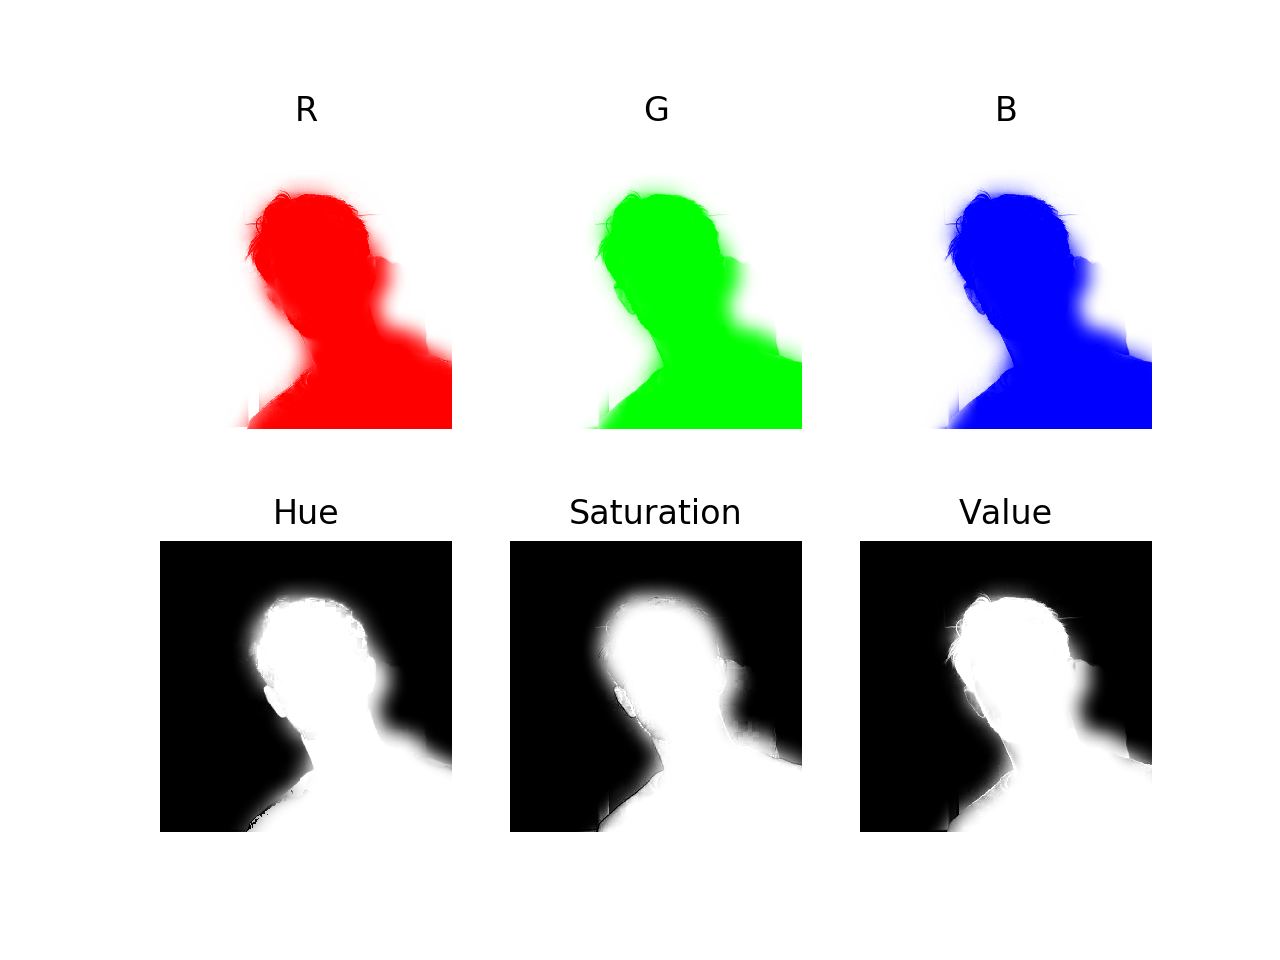

In [82]:
radius_px = 30
eps = 0.001

img_hsv = img_rgb.convert('HSV')
np_rgb = np.array(img_rgb, dtype='float32') / 255
np_hsv = np.array(img_hsv, dtype='float32') / 255

# Red
q_r = guided_filter(np_rgb[:,:,0], mask, radius_px, eps)
out_r = np.ones(np_rgb.shape)
out_r[:,:,1] = 1 - q_r
out_r[:,:,2] = 1 - q_r

# Green
q_g = guided_filter(np_rgb[:,:,1], mask, radius_px, eps)
out_g = np.ones(np_rgb.shape)
out_g[:,:,0] = 1 - q_g
out_g[:,:,2] = 1 - q_g

# Blue
q_b = guided_filter(np_rgb[:,:,2], mask, radius_px, eps)
out_b = np.ones(np_rgb.shape)
out_b[:,:,0] = 1 - q_b
out_b[:,:,1] = 1 - q_b

# Luminance
q_y = guided_filter(guide, mask, radius_px, eps)

# Hue
q_h = guided_filter(np_hsv[:,:,0], mask, radius_px, eps)

# Saturation
q_s = guided_filter(np_hsv[:,:,1], mask, radius_px, eps)

# Value
q_v = guided_filter(np_hsv[:,:,2], mask, radius_px, eps)


# Crop info
y = 625
x = 850
h = 900
w = 900


f, ax = plt.subplots(2,3)
ax[0,0].imshow(out_r[y:y+h,x:x+w,:])
ax[0,1].imshow(out_g[y:y+h,x:x+w,:])
ax[0,2].imshow(out_b[y:y+h,x:x+w,:])
# ax[1,0].imshow(q_y[y:y+h,x:x+w], cmap='gray')
ax[1,0].imshow(q_h[y:y+h,x:x+w], cmap='gray')
ax[1,1].imshow(q_s[y:y+h,x:x+w], cmap='gray')
ax[1,2].imshow(q_v[y:y+h,x:x+w], cmap='gray')
ax[0,0].set_title('R')
ax[0,1].set_title('G')
ax[0,2].set_title('B')
# ax[1,0].set_title('Y')
ax[1,0].set_title('Hue')
ax[1,1].set_title('Saturation')
ax[1,2].set_title('Value')
for i in range(ax.size):
    ax.flatten()[i].set_axis_off()
plt.show()

<IPython.core.display.Javascript object>


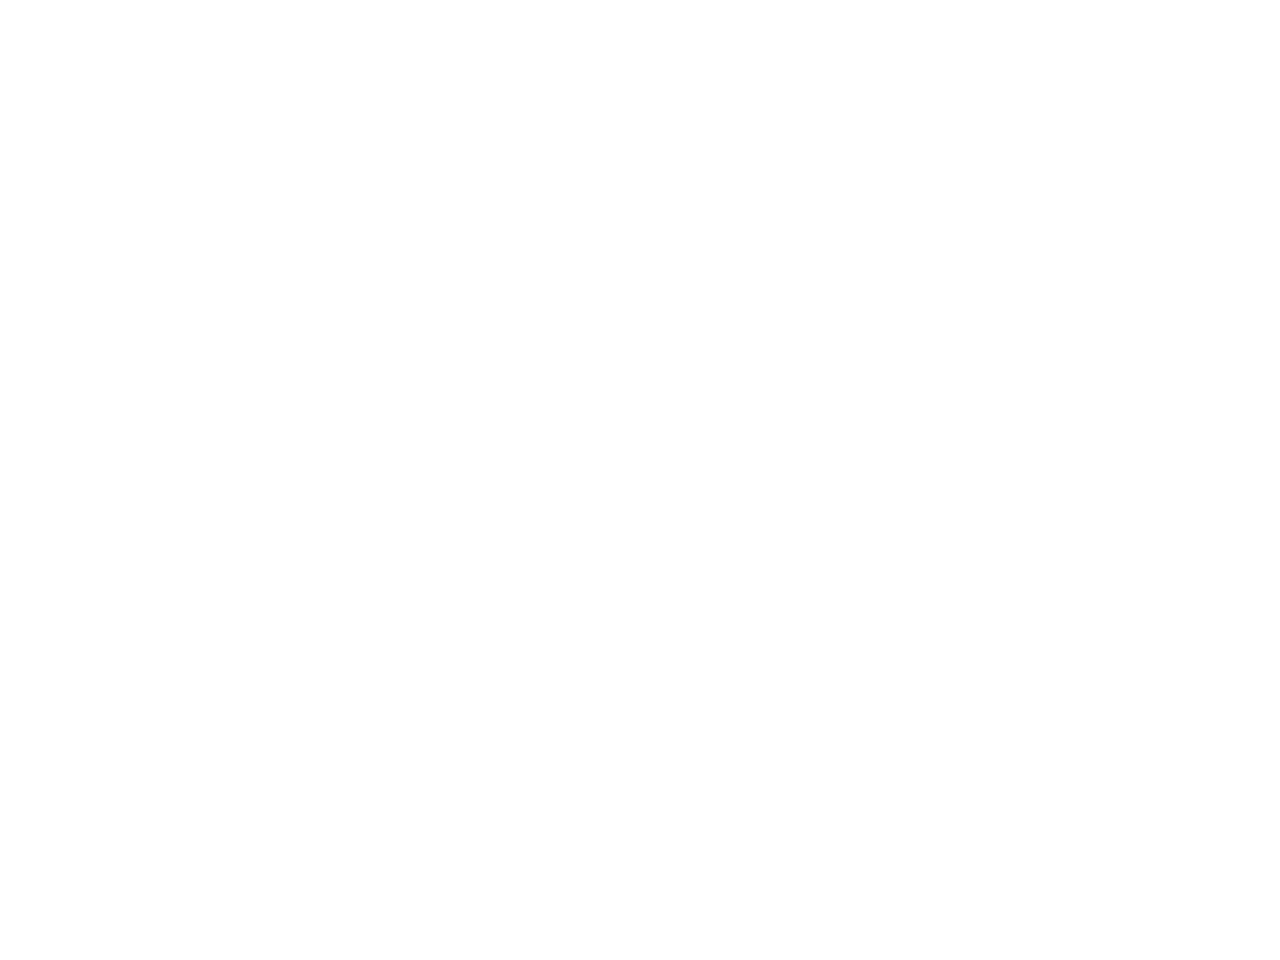

[[<matplotlib.axes._subplots.AxesSubplot object at 0x11fafe710>


In [65]:
f,ax = plt.subplots(3,5)
print(ax)

In [77]:
for i in range(ax.size):
    print(ax.flatten()[i].set_axis_off())

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
